# Project 242

## Import

In [437]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [438]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [439]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


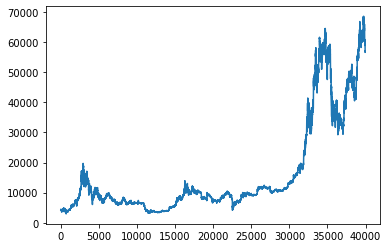

In [440]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [441]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [442]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [443]:
data = data.drop(['VWAP'], axis = 1)

In [444]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [445]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [446]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [447]:
# Add Signal
#q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

#train_data = add_signal(train_data, q_90)
#test_data = add_signal(test_data, q_90)
train_data['Signal'] = (train_data['Return'] >0).apply(int)
test_data['Signal'] = (test_data['Return'] >0).apply(int)

In [448]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (48.0%) | 0 (52.0%) | -1 (0.0%)
Test set: 1 (48.0%) | 0 (52.0%) | -1 (0.0%)


In [449]:
#display(train_data.head(2))
#display(test_data.head(2))

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [450]:
train = prepare_data_2D_format(train_data)
train.head()

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


,open_day_minus10,high_day_minus10,low_day_minus10,close_day_minus10,Volume_day_minus10,MOM_day_minus10,RSI_day_minus10,BB_high_day_minus10,BB_low_day_minus10,EMA_day_minus10,...,close_day_minus1,Volume_day_minus1,MOM_day_minus1,RSI_day_minus1,BB_high_day_minus1,BB_low_day_minus1,EMA_day_minus1,CCI_day_minus1,MACD_day_minus1,Signal
0,3887.98,3912.95,3876.40,3911.91,5413224.08,-3.145500,57.437621,3978.823255,3855.804078,3900.951243,...,3967.67,1.228500e+07,2.531167,62.175592,3979.281688,3871.216312,3911.270515,97.249733,2.531167,0
1,6577.28,6581.34,6510.08,6525.79,5669926.72,-19.651500,42.450075,6632.782437,6534.399563,6577.411094,...,6458.95,6.325934e+06,-82.654833,37.699456,6649.129708,6449.316292,6533.789232,-143.716772,-82.654833,0
2,10990.49,11003.09,10907.74,10914.51,24238462.04,31.960500,48.260721,11010.173386,10878.697947,10948.396950,...,10834.42,4.255119e+07,-66.244000,39.951601,11025.977396,10848.930604,10920.753361,-174.955694,-66.244000,0
3,9404.98,9431.65,9389.99,9420.93,10378788.07,-44.738000,55.441059,9556.487313,9366.008020,9411.145366,...,9558.90,2.271183e+07,-21.479333,61.220632,9557.500684,9339.009316,9422.011731,128.751868,-21.479333,0
4,7398.78,7444.99,7339.00,7443.99,8298933.56,65.101333,55.835657,7457.186889,7241.325777,7381.094494,...,7436.50,8.183768e+06,28.041500,54.251913,7484.564271,7285.087063,7400.028793,91.425548,28.041500,0


In [451]:
X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10, signal = True)
X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10, signal = True)

y_train = y_train[10:]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [452]:
## Remove empty lists in the beginning
while len(X_train[0]) == 0:
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) == 0:
    X_test = X_test[1:]
    y_test = y_test[1:]

In [453]:
from tqdm import tqdm
def format_2D(arr):
    res = []
    for item in arr:
        features = []
        for day in item:
            features += day.tolist()
        res.append(features)
    return res
X_train = format_2D(X_train)
X_test = format_2D(X_test)

In [454]:
## Some indicators have a larger lookback period than other. 
## We remove the beginning of the dataset to make everything homogeneous

while len(X_train[0]) != 10*len(data.columns):
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) != 10*len(data.columns):
    X_test = X_test[1:]
    y_test = y_test[1:]
    
X_train = np.array(X_train)
X_test = np.array(X_test)

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [455]:
features = []
for k in range(10):
    features = features + [col+"_day_minus"+str(10-k) for col in data.columns]

In [456]:
train = pd.DataFrame(X_train)
train.columns = features
train['Signal'] = pd.Series(y_train)

test = pd.DataFrame(X_test)
test.columns = features
test['Signal'] = pd.Series(y_test)

In [457]:
str_formula = 'Signal ~ '
for feat in features:
    str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [458]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.212
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           4.10e-58
Time:                        14:48:22   Log-Likelihood:                -21404.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29794   BIC:                         4.386e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6448    

We perform feature selection using the p-value

In [459]:
## remove high_day_minus4:
removed = ['high_day_minus4']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.261
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           2.01e-58
Time:                        14:48:25   Log-Likelihood:                -21404.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29795   BIC:                         4.385e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6446    

In [460]:
## remove Volume_day_minus2:
removed = ['high_day_minus4', 'Volume_day_minus2']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.298
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.68e-58
Time:                        14:48:29   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29796   BIC:                         4.384e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6448    

In [461]:
## remove Volume_day_minus8:
removed = ['high_day_minus4', 'Volume_day_minus2', 'Volume_day_minus8']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.352
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           7.31e-59
Time:                        14:48:31   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29797   BIC:                         4.383e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6448    

In [462]:
## remove MOM_day_minus6:
removed.append('MOM_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.352
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           7.31e-59
Time:                        14:48:41   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29797   BIC:                         4.383e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6448    

In [463]:
## remove MACD_day_minus6:
removed.append('MACD_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.401
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           4.04e-59
Time:                        14:48:48   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29798   BIC:                         4.382e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6446    

In [464]:
## remove high_day_minus3:
removed.append('high_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.457
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.72e-59
Time:                        14:48:51   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.300e+04
Df Residuals:                   29799   BIC:                         4.381e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6446    

In [465]:
## remove close_day_minus3:
removed.append('close_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.457
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.72e-59
Time:                        14:48:53   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.300e+04
Df Residuals:                   29799   BIC:                         4.381e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6446    

In [466]:
## remove EMA_day_minus10
removed.append('EMA_day_minus10')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.457
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.72e-59
Time:                        14:48:55   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.300e+04
Df Residuals:                   29799   BIC:                         4.381e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6446    

In [467]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.457
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.72e-59
Time:                        14:48:58   Log-Likelihood:                -21405.
No. Observations:               29896   AIC:                         4.300e+04
Df Residuals:                   29799   BIC:                         4.381e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6446    

In [468]:
## remove all EMAs
## EMAs are computed in a recurrent way, which is why they are so highly correlated
removed.append('EMA_day_minus8')
removed.append('EMA_day_minus7')
removed.append('EMA_day_minus6')
removed.append('EMA_day_minus5')
removed.append('EMA_day_minus4')
removed.append('EMA_day_minus3')
removed.append('EMA_day_minus2')
removed.append('EMA_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.348
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.62e-56
Time:                        14:48:59   Log-Likelihood:                -21416.
No. Observations:               29896   AIC:                         4.302e+04
Df Residuals:                   29801   BIC:                         4.381e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5749    

In [469]:
## remove close_day_minus5
removed.append('close_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.405
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           6.93e-57
Time:                        14:49:01   Log-Likelihood:                -21416.
No. Observations:               29896   AIC:                         4.302e+04
Df Residuals:                   29802   BIC:                         4.380e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5749    

In [470]:
## remove RSI_day_minus5
removed.append('RSI_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.461
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.33e-57
Time:                        14:49:02   Log-Likelihood:                -21416.
No. Observations:               29896   AIC:                         4.302e+04
Df Residuals:                   29803   BIC:                         4.379e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5749    

In [471]:
## remove RSI_day_minus1
removed.append('RSI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.519
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.51e-57
Time:                        14:49:04   Log-Likelihood:                -21416.
No. Observations:               29896   AIC:                         4.302e+04
Df Residuals:                   29804   BIC:                         4.378e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5725    

In [472]:
## remove high_day_minus2
removed.append('high_day_minus2')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.568
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.01e-57
Time:                        14:49:05   Log-Likelihood:                -21416.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29805   BIC:                         4.377e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5732    

In [473]:
## remove CCI_day_minus1
removed.append('CCI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.630
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           4.45e-58
Time:                        14:49:06   Log-Likelihood:                -21416.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29806   BIC:                         4.376e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5728    

In [474]:
## remove BB_low_day_minus3
removed.append('BB_low_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.679
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.12e-58
Time:                        14:49:08   Log-Likelihood:                -21417.
No. Observations:               29896   AIC:                         4.301e+04
Df Residuals:                   29807   BIC:                         4.375e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5733    

In [475]:
y_prob = reg.predict(test)

def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < 0.5: return 0
    return 1

y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]),
        '0': len([x for x in y_pred if x == 0])}
print(freq)

{'1': 2, '0': 9966}


### 3. Test prediction model

In [476]:
TPR, FPR = 0, 0 #get_TPR_FPR(y_test, y_pred)
F1 = get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [477]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.519964,0.342278,0


### III. Strategy

### 1. Get data ready for backtesting

In [478]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [479]:
def translation(x):
    if x == 0: return -1
    return x

In [480]:
signal = pd.Series(y_pred).apply(translation)
close = test_data.close
signal.describe()

count    9968.000000
mean       -0.999599
std         0.028328
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max         1.000000
dtype: float64

In [481]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [482]:
strat = Strategy(cash=500, fees=0.001)

In [483]:
strat.run(signal_crop, close_crop, verbose=False)

In [484]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

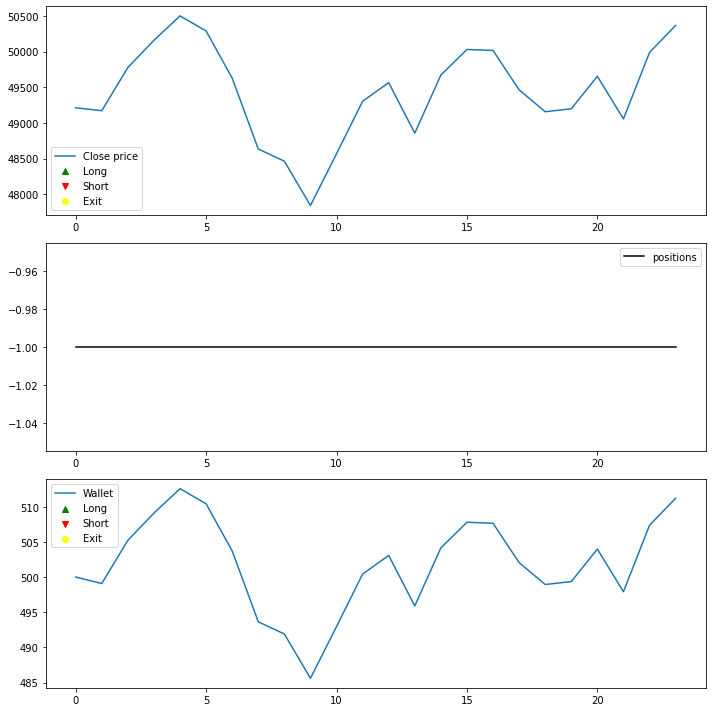

In [485]:
strat.visualize()

### 3. Test performance startegy

In [486]:
l_SharpeRatio = SharpeRatio(profit)
l_MaxDrawback = MaxDrawback(profit)
l_WinLossRatio = WinLossRatio(profit)
l_CumulativeProfit = CumulativeProfit(profit)
l_MeanProfit = MeanProfit(profit)

In [487]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[l_SharpeRatio, l_MaxDrawback, l_WinLossRatio, l_CumulativeProfit, l_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,-0.08601,-9.443047,0.916667,-11.203402,-0.466808
